In [1]:
### Python
import os
import random
import time
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, cm
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from math import ceil
import seaborn as sns

### Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data
import segmentation_models_pytorch as smp
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchsummary import summary

### Others
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

### Images
import cv2
from PIL import Image

#my classes
import dataset as customdataset
import my_functions


In [2]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)

All the variables regarding the ground truth generation and the model are set in the following cell

In [3]:
index = 150

sigma = 12
threshold = 1e-4
re_scale = 1e5
p_x,p_y =320,320
#p_x,p_y =384,640

max_epochs        = 201
learning_rate     = 5e-4

images_path = f"../Images/VGG_{index}_"
model_path = f'../Models/VGG16_{sigma}_{threshold}_{re_scale}_{index}.pth'


ft_max_epochs        = 101
ft_learning_rate     = 5e-4
ft_images_path = f"../Images/VGG_{index}_"
ft_model_path = f'../Models/VGG16_{sigma}_{threshold}_{re_scale}_{index}_fine_tune.pth'

In [4]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [5]:
torch.cuda.is_available()

False

# Import corn dataset

In [5]:
#path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"
path = "../Data/corn_kernel_counting_dataset/"

categorie = "corn"

train_csv_positions  = path + f"{categorie}_coco/{categorie}_kernel_train_positions.csv" 
train_csv_info       = path + f"{categorie}_coco/{categorie}_kernel_train_info.csv"
train_data_path = path + f"{categorie}_coco" 

test_csv_positions  = path + f"{categorie}_coco/{categorie}_kernel_test_positions.csv" 
test_csv_info       = path + f"{categorie}_coco/{categorie}_kernel_test_info.csv"
test_data_path = path + f"{categorie}_coco" 

In [6]:
### Define dataset
train_dataset = customdataset.CustomImageDataset(train_csv_positions,train_csv_info,train_data_path,
                                           threshold=threshold,re_scale=re_scale,
                                           img_transforms=transforms.ToTensor(),
                                           mask_transforms=transforms.ToTensor(),
                                           I_M_transforms=None)

test_dataset = customdataset.CustomImageDataset(test_csv_positions,test_csv_info,test_data_path,
                                           threshold=threshold,re_scale=re_scale,
                                           img_transforms=transforms.ToTensor(),
                                           mask_transforms=transforms.ToTensor(),
                                           I_M_transforms=None)

In [7]:
print("max",train_dataset[0][0].amax(axis= [1,2]))
print("min",train_dataset[0][0].amin(axis= [1,2]))

train_mean, train_std = my_functions.dataset_mean_std(train_dataset)
# Mean and std should be divided by 255 (maximum pixel value)
# because, after the ToTensor() transformation (see next step), images are normalized
# between 0 and 1.
#train_mean, train_std =train_mean/255, train_std/255
# output
print('mean: '  + str(train_mean))
print('std:  '  + str(train_std))

max tensor([1., 1., 1.])
min tensor([0., 0., 0.])
mean: tensor([0.5070, 0.4383, 0.3099])
std:  tensor([0.2985, 0.2740, 0.2705])


In [8]:
# Split train data into train and validation sets
# (10% of training set will be used as validation set)
num_train_examples = int(len(train_dataset) * 0.80)
num_valid_examples = len(train_dataset) - num_train_examples

print(f"Number of training examples: {num_train_examples}")

Number of training examples: 193


In [9]:
# Create 'Subset' objects
train_dataset, validation_dataset = data.random_split(train_dataset, [num_train_examples, num_valid_examples])

print(f"Number training examples: {len(train_dataset)}")
print(f"Number validation examples: {len(validation_dataset)}")
print(f"Number test examples: {len(test_dataset)}")

Number training examples: 193
Number validation examples: 49
Number test examples: 62


In [10]:
# Apply test transformations to the validation set
validation_dataset = copy.deepcopy(validation_dataset) # If we change train transformations, this won't affect the validation set


In [12]:
train_img_transforms,train_geometric_transforms,lbl_transforms,validation_img_transforms,validation_geometric_transforms,test_img_transforms,test_geometric_transforms = my_functions.transforms_definitions_cropped_image(pd_1=p_x,pd_2=p_y)

In [13]:
### Update transforms for the datasets and the corresponding iterators
# Train dataset
train_dataset.dataset.I_M_transforms    = train_geometric_transforms
train_dataset.dataset.img_transforms    = train_img_transforms
train_dataset.dataset.mask_transforms   = lbl_transforms
train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True, num_workers=0,pin_memory=True)

# Validation dataset
validation_dataset.dataset.I_M_transforms    = validation_geometric_transforms
validation_dataset.dataset.img_transforms    = validation_img_transforms
validation_dataset.dataset.mask_transforms   = lbl_transforms
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False, num_workers=0,pin_memory=True)

# test dataset
test_dataset.I_M_transforms    = test_geometric_transforms
test_dataset.img_transforms    = test_img_transforms
test_dataset.mask_transforms   = lbl_transforms
# For flexibility i dont define it
##test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)


Training dataloader 

In [14]:
start_time = time.time()
train_images, train_masks, shape,count = next(iter(train_dataloader))
end_time = time.time()
print(f"Dataloader Time: {end_time-start_time:.2f} s")

Dataloader Time: 1.81 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


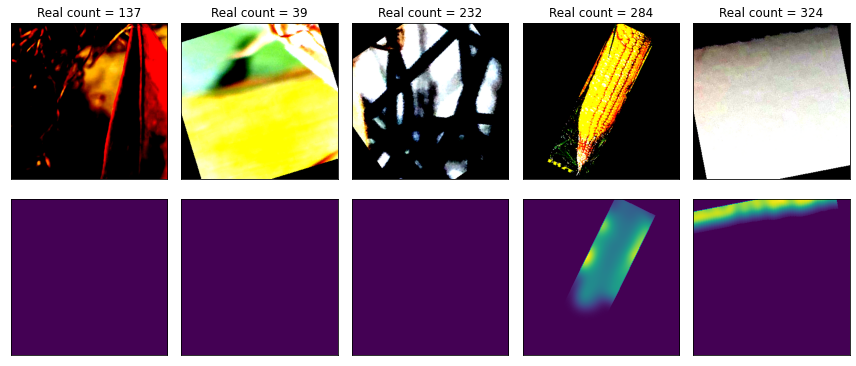

In [15]:
#my_functions.reconstruct_plot_images_masks(train_images, train_masks, shape,count)
my_functions.Non_reconstruct_plot_images_masks(train_images, train_masks, shape,count)

Validation dataloader

In [16]:
start_time = time.time()
validation_images, validation_masks, shape,count = next(iter(validation_dataloader))
end_time = time.time()
print(f"Dataloader Time: {end_time-start_time:.2f} s")

Dataloader Time: 3.50 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


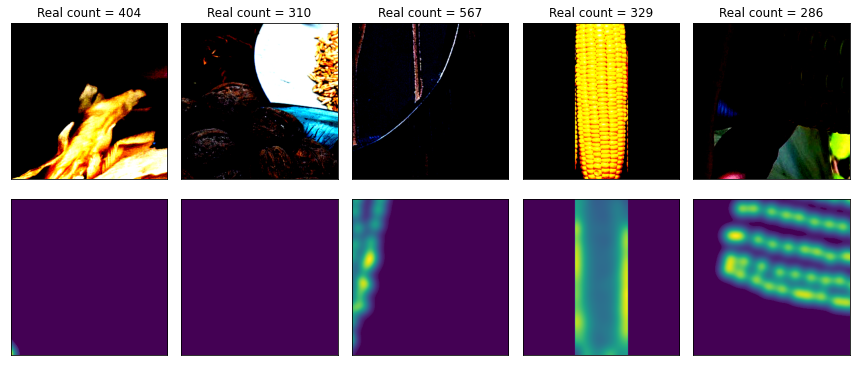

In [17]:
#my_functions.reconstruct_plot_images_masks(test_images, test_masks, shape,count)
my_functions.Non_reconstruct_plot_images_masks(validation_images, validation_masks, shape,count)

Test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


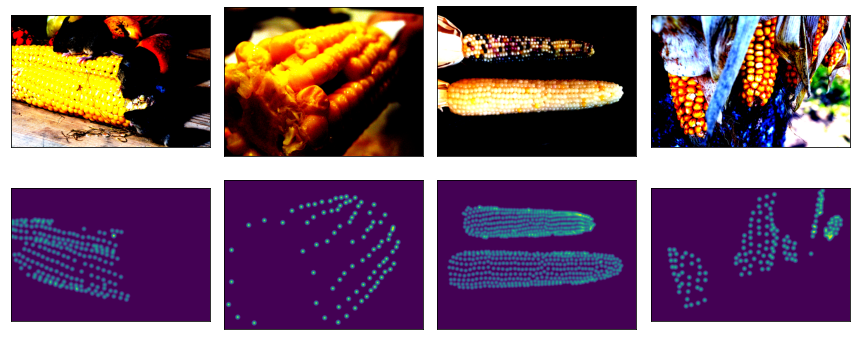

In [18]:
my_functions.plot_dataset_data(test_dataset)

# Architecture

In [19]:
###############
# VGG
###############

### Load pretrained model
VGG16 = smp.Unet('vgg16', encoder_weights='imagenet',decoder_use_batchnorm =False,decoder_attention_type =None,encoder_depth =2,decoder_channels= [128,64])
### Define the model
model = VGG16

In [20]:
#summary(model, (3, 320, 320))

In [21]:
### Disable the weight update for the trained encoder
for param_name, param in model.encoder.named_parameters():
    param.requires_grad = False

### Allow weight update (training) of the last layers (linear layers)
for param in model.decoder.parameters():
    param.requires_grad = True

### Check which weights and biases will be updated
#for param_name, param in model.named_parameters():
    #print(param_name,param.requires_grad)

In [22]:
#summary(model, (3, 384, 640))

In [23]:
### Define the loss function for reconstruction
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Send model to device
model.to(device);

RuntimeError: No CUDA GPUs are available

In [23]:
writer = SummaryWriter(f"../runs/VGG16")
#writer = SummaryWriter()
train_loss, test_loss = my_functions.training_cycle(model,
                                                    device,
                                                    train_dataloader,
                                                    validation_dataloader,
                                                    validation_dataset,
                                                    loss_fn,
                                                    optimizer,
                                                    max_epochs,
                                                    writer,
                                                    model_path,
                                                    images_path,
                                                    verbose=False)
### To end TensorBoard writings
writer.close()

  0%|          | 0/201 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 1/201 [07:55<26:24:06, 475.23s/it]


KeyboardInterrupt: 

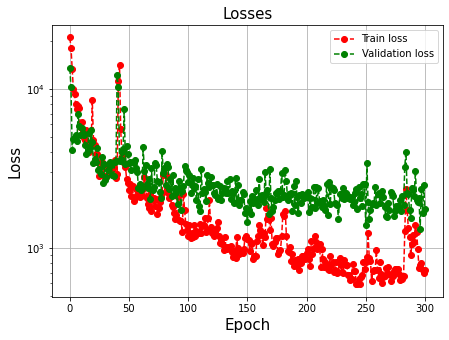

In [56]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test_loss, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
#plt.ylim(0,80)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('../Images/losses.svg', format='svg')
plt.show()

# Evaluation

The evaluation of the model is done on the base dataset and also on the narrow dataset.

## Loading of the saved model

In [57]:
###############
# VGG
###############

### Load pretrained model
#VGG16 = smp.Unet('vgg16', encoder_weights='imagenet')
VGG16 = smp.Unet('vgg16', encoder_weights='imagenet',decoder_use_batchnorm =False,decoder_attention_type =None,encoder_depth =2,decoder_channels= [128,64])
### Define the model
model = VGG16

#Send model to device
model.to(device);

In [58]:
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

## Real testing

In [59]:
#############################
### Evaluation on test set
#############################
final_output = []
for idx in range(len(test_dataset)):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels, shapes, counts = test_dataset[idx]
    padded_image,image_sections   = my_functions.image_disector(inputs,window_h=p_x,window_w=p_y)
    #padded_labels,labels_sections = my_functions.image_disector(labels,window_h=384,window_w=640)
        
    image_sections_predictions = []
    for images in image_sections:
        images = images.to(device)
        model.eval()
        with torch.no_grad():
            # forward 
            #pred = 
            image_sections_predictions.append(model(images[None, :])[0])
            #plt.imshow(image_sections_predictions[-1][0][0].numpy())
            #plt.show()
            
    final_output.append(my_functions.map_reconstruction(inputs.shape,padded_image,image_sections_predictions,window_h=p_x,window_w=p_y)[0])
            

Plot a few inferences

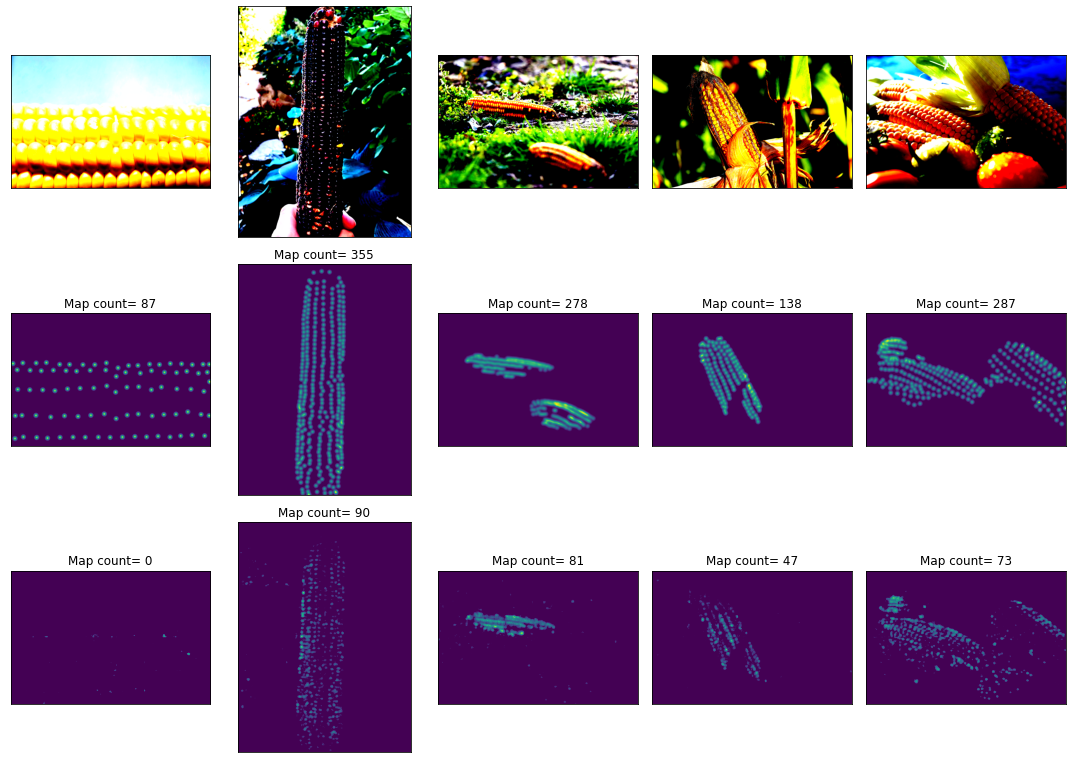

In [60]:
elements = [random.randint(1,40)for i in range(0,5)]#[5,6,7,8,9]

fig, axs = plt.subplots(3, 5, figsize=(15,12))
fig.suptitle("",fontsize=15)
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
for i in range(5):
    idx = elements[i]
    ### Move the images to the right shapes
    img = test_dataset[idx][0].numpy().transpose(1, 2, 0)
    label = test_dataset[idx][1][0].numpy()
    map_ = final_output[idx].cpu().numpy()
    map_[map_<30] = 0
    map_[map_>250] = 0
    # Plot the reconstructed image
    axs[i].imshow(img)
    #axs[i].set_title(f"Real count = {counts[idx]}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+5].imshow(label,cmap="viridis")
    axs[i+5].set_title(f"Map count= {int(label.sum()/re_scale)}")
    axs[i+5].set_xticks([])
    axs[i+5].set_yticks([])
    axs[i+10].imshow(map_,cmap="viridis")
    axs[i+10].set_title(f"Map count= {int(map_.sum()/re_scale)}")
    axs[i+10].set_xticks([])
    axs[i+10].set_yticks([])
plt.tight_layout()
fig.subplots_adjust(top=0.88)

### Evaluation metrics

In [68]:
label_count_list = []
map_count_list = []
for idx in [i for i in range(len(test_dataset))]:
    ### Move the images to the right shapes
    map_ = final_output[idx].cpu().numpy()
    
    label = test_dataset[idx][1][0].numpy()
    label_count = int(label.sum()/re_scale)
    label_count_list.append(label_count)
    
    map_ = final_output[idx].cpu().numpy()
    #map_[map_<30] = 0
    #map_[map_>250] = 0
    map_count = int(map_.sum()/re_scale)
    map_count_list.append(map_count)

In [69]:
mae = np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list)))/len(map_count_list)
print("MAE = ", mae)

rmse = np.sqrt(np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list))**2)/len(map_count_list))
print("RMSE = ", rmse)

mape = np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list))/np.array(label_count_list)) /len(map_count_list)
print("MAPE = ", mape)

MAE =  111.54838709677419
RMSE =  178.24910079852822
MAPE =  0.5584580542864248


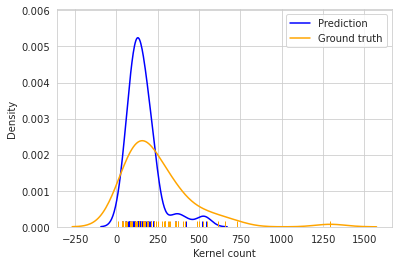

In [70]:
sns.set_style('whitegrid')
sns.kdeplot(map_count_list,
             color = 'blue',
             label="Prediction")
sns.rugplot(map_count_list,color = 'blue')
sns.kdeplot(label_count_list,
             color = 'orange',
             label="Ground truth")
sns.rugplot(label_count_list,color = 'orange')

# Plot formatting
#plt.title('Density Plot with Rug Plot for kernel count')
plt.xlabel('Kernel count')
plt.ylabel('Density')
plt.legend()
plt.show()

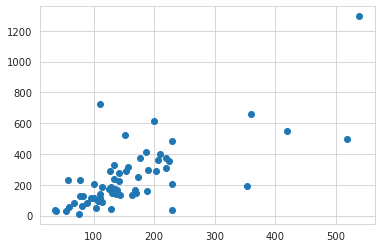

In [71]:
plt.scatter(map_count_list,label_count_list)

Now we study the impact on the background blancket in the final count

In [72]:
idx = 2
prediction = np.copy(final_output[idx].cpu().numpy())
real       = np.copy(test_dataset[idx][1][0].numpy())

In [75]:
prediction_2 = np.copy(prediction)
prediction_2[prediction_2<30] = 0
#prediction_2[prediction_2>250] = 0

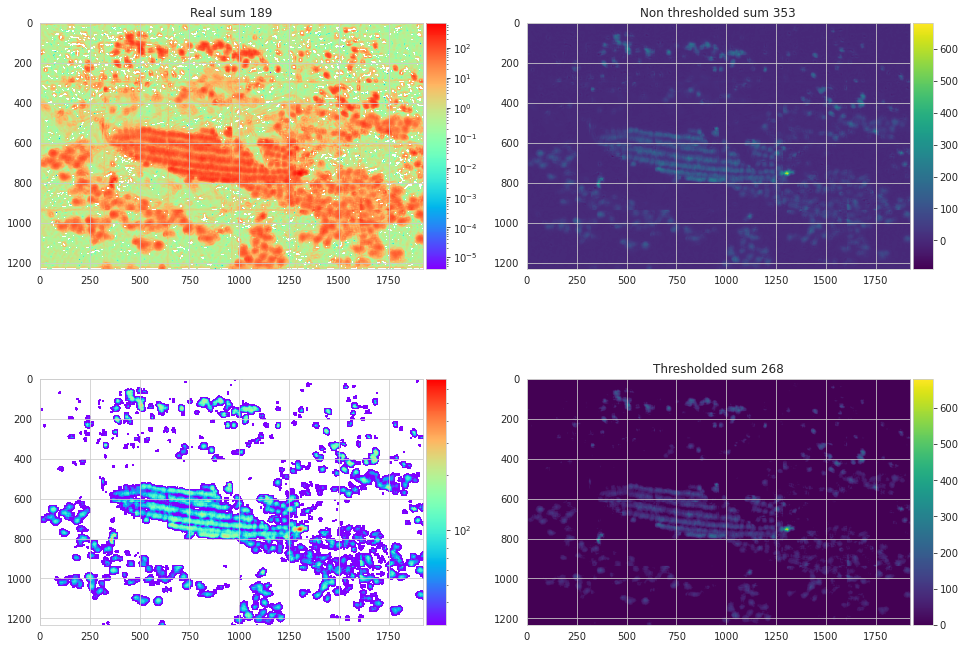

In [76]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(221)
im1 = ax1.imshow(prediction, cmap=cm.rainbow, norm=colors.LogNorm())
ax1.set_title(f"Real sum {int(real.sum()/re_scale)}")
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(prediction,cmap="viridis")
ax2.set_title(f"Non thresholded sum {int(prediction.sum()/re_scale)}")
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(prediction_2, cmap=cm.rainbow, norm=colors.LogNorm())
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical');

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(prediction_2,cmap="viridis")
ax4.set_title(f"Thresholded sum {int(prediction_2.sum()/re_scale)}")
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical');

# Load the narrow dataset

In [77]:
#path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"
path = "../Data/corn_kernel_counting_dataset/"

categorie = "narrow"

train_csv_positions  = path + f"{categorie}_coco/{categorie}_kernel_train_positions.csv" 
train_csv_info       = path + f"{categorie}_coco/{categorie}_kernel_train_info.csv"
train_data_path = path + f"{categorie}_coco" 

test_csv_positions  = path + f"{categorie}_coco/{categorie}_kernel_test_positions.csv" 
test_csv_info       = path + f"{categorie}_coco/{categorie}_kernel_test_info.csv"
test_data_path = path + f"{categorie}_coco" 


In [78]:
### Define dataset
train_dataset = customdataset.CustomImageDataset(train_csv_positions,train_csv_info,train_data_path,
                                           threshold=threshold,re_scale=re_scale,
                                           img_transforms=transforms.ToTensor(),
                                           mask_transforms=transforms.ToTensor(),
                                           I_M_transforms=None)

test_dataset = customdataset.CustomImageDataset(test_csv_positions,test_csv_info,test_data_path,
                                           threshold=threshold,re_scale=re_scale,
                                           img_transforms=transforms.ToTensor(),
                                           mask_transforms=transforms.ToTensor(),
                                           I_M_transforms=None)


In [79]:
# Split train data into train and validation sets
# (10% of training set will be used as validation set)
num_train_examples = int(len(train_dataset) * 0.99)
num_valid_examples = len(train_dataset) - num_train_examples

print(f"Number of training examples: {num_train_examples}")


Number of training examples: 47


In [80]:
# Create 'Subset' objects
train_dataset, validation_dataset = data.random_split(train_dataset, [num_train_examples, num_valid_examples])

print(f"Number training examples: {len(train_dataset)}")
print(f"Number validation examples: {len(validation_dataset)}")
print(f"Number test examples: {len(test_dataset)}")

Number training examples: 47
Number validation examples: 1
Number test examples: 12


In [81]:
# Apply test transformations to the validation set
validation_dataset = copy.deepcopy(validation_dataset) # If we change train transformations, this won't affect the validation set


In [82]:
train_img_transforms,train_geometric_transforms,lbl_transforms,validation_img_transforms,validation_geometric_transforms,test_img_transforms,test_geometric_transforms = my_functions.transforms_definitions_cropped_image(pd_1=p_x,pd_2=p_y)

In [83]:
### Update transforms for the datasets and the corresponding iterators
# Train dataset
train_dataset.dataset.I_M_transforms    = train_geometric_transforms
train_dataset.dataset.img_transforms    = train_img_transforms
train_dataset.dataset.mask_transforms   = lbl_transforms
train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True, num_workers=0,pin_memory=True)

# Validation dataset
validation_dataset.dataset.I_M_transforms    = validation_geometric_transforms
validation_dataset.dataset.img_transforms    = validation_img_transforms
validation_dataset.dataset.mask_transforms   = lbl_transforms
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False, num_workers=0,pin_memory=True)

# test dataset
test_dataset.I_M_transforms    = test_geometric_transforms
test_dataset.img_transforms    = test_img_transforms
test_dataset.mask_transforms   = lbl_transforms
# For flexibility i dont define it
##test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)


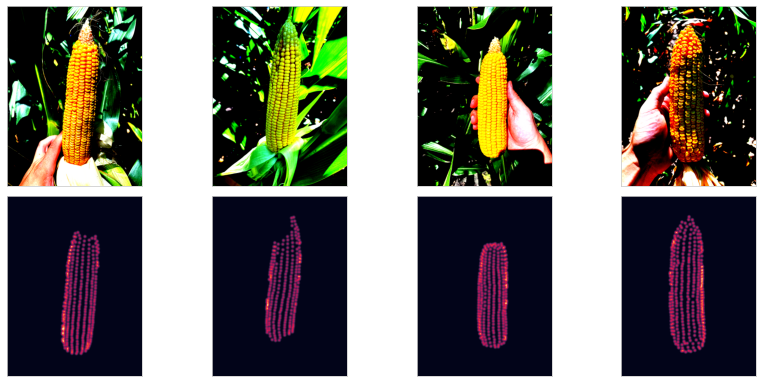

In [84]:
my_functions.plot_dataset_data(test_dataset)

## Evaluation on narrow

In [ ]:
###############
# VGG
###############

### Load pretrained model
VGG16 = smp.Unet('vgg16', encoder_weights='imagenet')
### Define the model
model = VGG16

#Send model to device
model.to(device);

In [ ]:
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'])

In [85]:
#############################
### Evaluation on test set
#############################
final_output = []
for idx in range(len(test_dataset)):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels, shapes, counts = test_dataset[idx]
    padded_image,image_sections   = my_functions.image_disector(inputs,window_h=p_x,window_w=p_y)
    #padded_labels,labels_sections = my_functions.image_disector(labels,window_h=384,window_w=640)
        
    image_sections_predictions = []
    for images in image_sections:
        images = images.to(device)
        model.eval()
        with torch.no_grad():
            # forward 
            #pred = 
            image_sections_predictions.append(model(images[None, :])[0])
            #plt.imshow(image_sections_predictions[-1][0][0].numpy())
            #plt.show()
            
    final_output.append(my_functions.map_reconstruction(inputs.shape,padded_image,image_sections_predictions,window_h=p_x,window_w=p_y)[0])


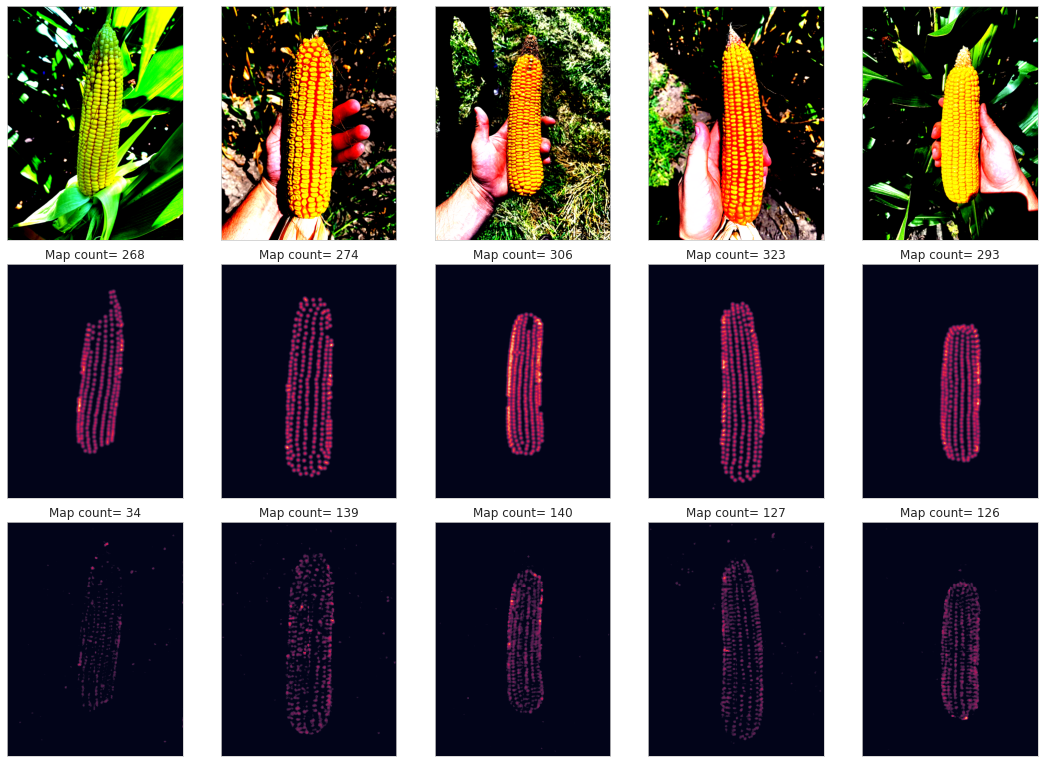

In [86]:
elements = random.sample(range(len(test_dataset)), 5)#[random.randint(1,5)for i in range(0,5)]#[5,6,7,8,9]

fig, axs = plt.subplots(3, 5, figsize=(15,12))
fig.suptitle("",fontsize=15)
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
for i in range(5):
    idx = elements[i]
    ### Move the images to the right shapes
    img = test_dataset[idx][0].numpy().transpose(1, 2, 0)
    label = test_dataset[idx][1][0].numpy()
    map_ = final_output[idx].cpu().numpy()
    map_[map_<30] = 0
    map_[map_>250] = 0
    # Plot the reconstructed image
    axs[i].imshow(img)
    #axs[i].set_title(f"Real count = {counts[idx]}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+5].imshow(label)
    axs[i+5].set_title(f"Map count= {int(label.sum()/re_scale)}")
    axs[i+5].set_xticks([])
    axs[i+5].set_yticks([])
    axs[i+10].imshow(map_)
    axs[i+10].set_title(f"Map count= {int(map_.sum()/re_scale)}")
    axs[i+10].set_xticks([])
    axs[i+10].set_yticks([])
plt.tight_layout()
fig.subplots_adjust(top=0.88)

In [94]:
label_count_list = []
map_count_list = []
for idx in [i for i in range(len(test_dataset))]:
    ### Move the images to the right shapes
    map_ = final_output[idx].cpu().numpy()
    
    label = test_dataset[idx][1][0].numpy()
    label_count = int(label.sum()/re_scale)
    label_count_list.append(label_count)
    
    map_ = final_output[idx].cpu().numpy()
    #map_[map_<30] = 0
    #map_[map_>250] = 0
    map_count = int(map_.sum()/re_scale)
    map_count_list.append(map_count)

In [95]:
mae = np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list)))/len(map_count_list)
print("MAE = ", mae)

rmse = np.sqrt(np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list))**2)/len(map_count_list))
print("RMSE = ", rmse)

mape = np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list))/np.array(label_count_list)) /len(map_count_list)
print("MAPE = ", mape)

MAE =  59.333333333333336
RMSE =  69.54135460285484
MAPE =  0.20095993147624303


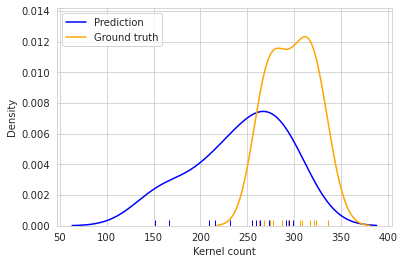

In [96]:
sns.set_style('whitegrid')
sns.kdeplot(map_count_list,
             color = 'blue',
             label="Prediction")
sns.rugplot(map_count_list,color = 'blue')
sns.kdeplot(label_count_list,
             color = 'orange',
             label="Ground truth")
sns.rugplot(label_count_list,color = 'orange')

# Plot formatting
#plt.title('Density Plot with Rug Plot for kernel count')
plt.xlabel('Kernel count')
plt.ylabel('Density')
plt.legend()
plt.show()

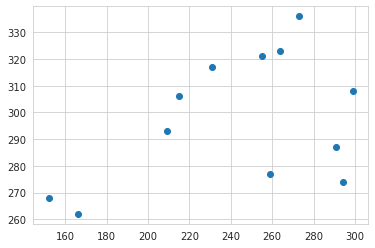

In [97]:
plt.scatter(map_count_list,label_count_list)

In [98]:
idx = 2
prediction = np.copy(final_output[idx].cpu().numpy())
real       = np.copy(test_dataset[idx][1][0].numpy())

In [104]:
real.mean()

7.6515574

In [105]:
prediction_2 = np.copy(prediction)
prediction_2[prediction_2<7] = 0
#prediction_2[prediction_2>250] = 0

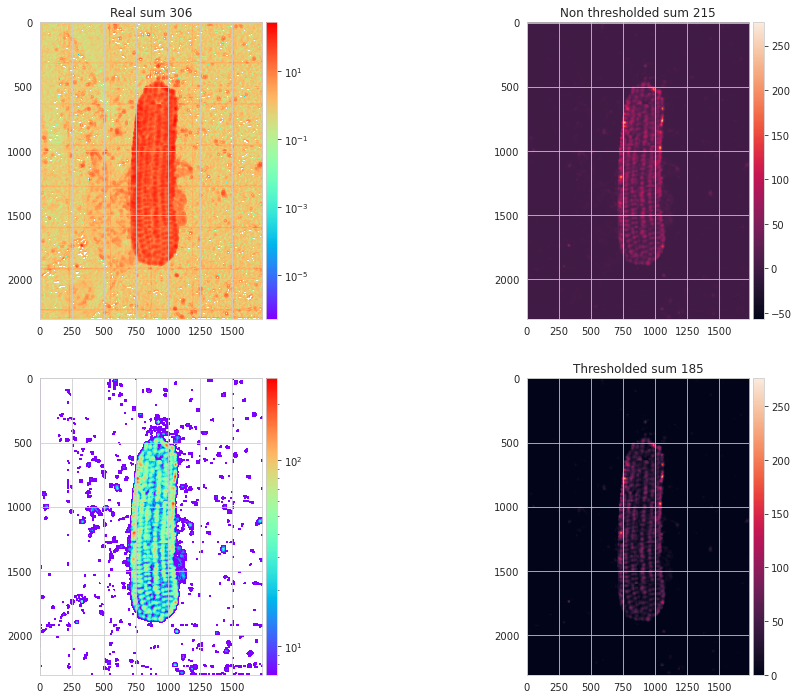

In [106]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(221)
im1 = ax1.imshow(prediction, cmap=cm.rainbow, norm=colors.LogNorm())
ax1.set_title(f"Real sum {int(real.sum()/re_scale)}")
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(prediction)
ax2.set_title(f"Non thresholded sum {int(prediction.sum()/re_scale)}")
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(prediction_2, cmap=cm.rainbow, norm=colors.LogNorm())
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical');

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(prediction_2)
ax4.set_title(f"Thresholded sum {int(prediction_2.sum()/re_scale)}")
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical');

## Fine tuning

In [112]:
###############
# VGG
###############

### Load pretrained model
VGG16 = smp.Unet('vgg16', encoder_weights='imagenet',decoder_use_batchnorm =False,decoder_attention_type =None,encoder_depth =2,decoder_channels= [128,64])
### Define the model
model = VGG16

In [113]:
### Disable the weight update for the trained encoder
for param_name, param in model.encoder.named_parameters():
    param.requires_grad = False

### Allow weight update (training) of the last layers (linear layers)
for param in model.decoder.parameters():
    param.requires_grad = True

### Check which weights and biases will be updated
#for param_name, param in model.named_parameters():
#    print(param_name,param.requires_grad)

In [114]:
### Define the loss function for reconstruction
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
optimizer = torch.optim.Adam(model.parameters(), lr=ft_learning_rate)

# # Check if the GPU is available
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'Selected device: {device}')

#Send model to device
model.to(device)

Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

### Load pre trained model

In [115]:
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [116]:
writer = SummaryWriter(f"../runs/VGG16")
#writer = SummaryWriter()
train_loss, test_loss = my_functions.training_cycle(model,
                                                    device,
                                                    train_dataloader,
                                                    validation_dataloader,
                                                    validation_dataset,
                                                    loss_fn,
                                                    optimizer,
                                                    ft_max_epochs,
                                                    writer,
                                                    ft_model_path,
                                                    ft_images_path,
                                                    verbose=False)
### To end TensorBoard writings
writer.close()

100%|██████████| 121/121 [14:56<00:00,  7.41s/it]


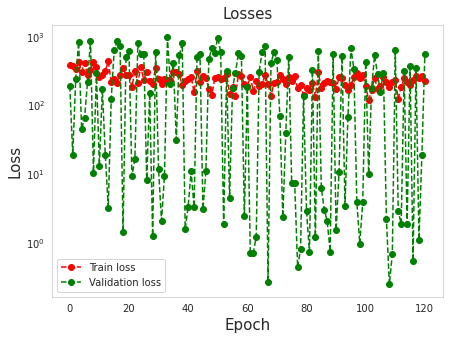

In [117]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test_loss, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
#plt.ylim(0,80)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('../Images/losses.svg', format='svg')
plt.show()

## Evaluation on narrow

In [118]:
###############
# VGG
###############

### Load pretrained model
VGG16 = smp.Unet('vgg16', encoder_weights='imagenet',decoder_use_batchnorm =False,decoder_attention_type =None,encoder_depth =2,decoder_channels= [128,64])
### Define the model
model = VGG16

Load the fine tuned model

In [119]:
checkpoint = torch.load(ft_model_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [120]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
model.to(device)

Selected device: cuda


Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [121]:
#############################
### Evaluation on test set
#############################
final_output = []
for idx in range(len(test_dataset)):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels, shapes, counts = test_dataset[idx]
    padded_image,image_sections   = my_functions.image_disector(inputs,window_h=p_x,window_w=p_y)
    #padded_labels,labels_sections = my_functions.image_disector(labels,window_h=384,window_w=640)
        
    image_sections_predictions = []
    for images in image_sections:
        images = images.to(device)
        model.eval()
        with torch.no_grad():
            # forward 
            #pred = 
            image_sections_predictions.append(model(images[None, :])[0])
            #plt.imshow(image_sections_predictions[-1][0][0].numpy())
            #plt.show()
            
    final_output.append(my_functions.map_reconstruction(inputs.shape,padded_image,image_sections_predictions,window_h=p_x,window_w=p_y)[0])


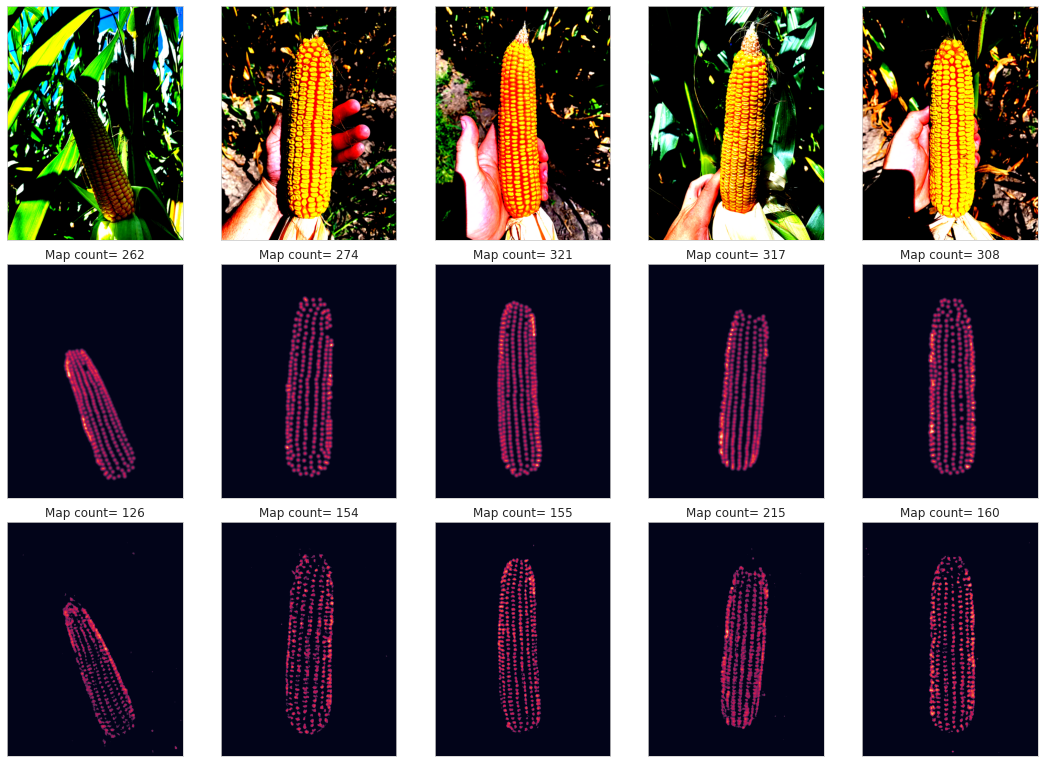

In [122]:
elements = random.sample(range(len(test_dataset)), 5)#[random.randint(1,5)for i in range(0,5)]#[5,6,7,8,9]

fig, axs = plt.subplots(3, 5, figsize=(15,12))
fig.suptitle("",fontsize=15)
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
for i in range(5):
    idx = elements[i]
    ### Move the images to the right shapes
    img = test_dataset[idx][0].numpy().transpose(1, 2, 0)
    label = test_dataset[idx][1][0].numpy()
    map_ = final_output[idx].cpu().numpy()
    map_[map_<50] = 0
    map_[map_>250] = 0
    
    # Plot the reconstructed image
    axs[i].imshow(img)
    #axs[i].set_title(f"Real count = {counts[idx]}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+5].imshow(label)
    axs[i+5].set_title(f"Map count= {int(label.sum()/re_scale)}")
    axs[i+5].set_xticks([])
    axs[i+5].set_yticks([])
    axs[i+10].imshow(map_)
    axs[i+10].set_title(f"Map count= {int(map_.sum()/re_scale)}")
    axs[i+10].set_xticks([])
    axs[i+10].set_yticks([])
plt.tight_layout()
fig.subplots_adjust(top=0.88)

In [123]:
label_count_list = []
map_count_list = []
for idx in [i for i in range(len(test_dataset))]:
    ### Move the images to the right shapes
    #map_ = final_output[idx].cpu().numpy()
    label = test_dataset[idx][1][0].numpy()
    label_count = int(label.sum()/re_scale)
    label_count_list.append(label_count)
    
    map_ = final_output[idx].cpu().numpy()
    map_[map_<30] = 0
    map_[map_>250] = 0
    map_count = int(map_.sum()/re_scale)
    map_count_list.append(map_count)

In [124]:
mae = np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list)))/len(map_count_list)
print("MAE = ", mae)

rmse = np.sqrt(np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list))**2)/len(map_count_list))
print("RMSE = ", rmse)

mape = np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list))/np.array(label_count_list)) /len(map_count_list)
print("MAPE = ", mape)

MAE =  63.75
RMSE =  70.60158166311385
MAPE =  0.21184284398297937


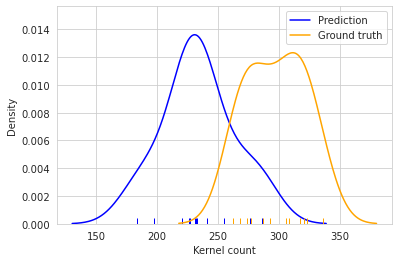

In [125]:
sns.set_style('whitegrid')
sns.kdeplot(map_count_list,
             color = 'blue',
             label="Prediction")
sns.rugplot(map_count_list,color = 'blue')
sns.kdeplot(label_count_list,
             color = 'orange',
             label="Ground truth")
sns.rugplot(label_count_list,color = 'orange')

# Plot formatting
#plt.title('Density Plot with Rug Plot for kernel count')
plt.xlabel('Kernel count')
plt.ylabel('Density')
plt.legend()
plt.show()

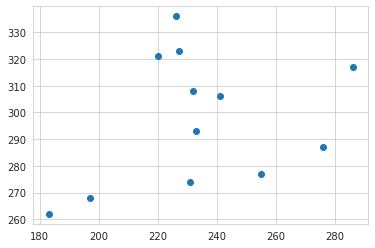

In [126]:
plt.scatter(map_count_list,label_count_list)

In [127]:
idx = 4
prediction = np.copy(final_output[idx].cpu().numpy())
real       = np.copy(test_dataset[idx][1][0].numpy())

In [128]:
prediction_2 = np.copy(prediction)
prediction_2[prediction_2<30] = 0
prediction_2[prediction_2>250] = 0
lala = np.zeros(prediction_2.shape)
lala[250:2100,500:1100] = prediction_2[250:2100,500:1100]

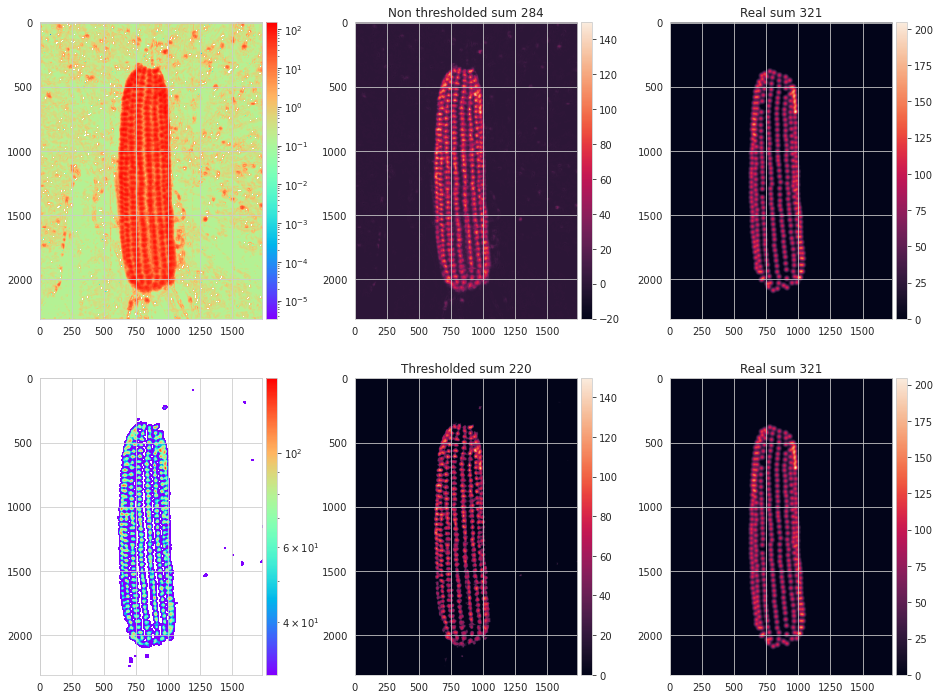

In [129]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(231)
im1 = ax1.imshow(prediction, cmap=cm.rainbow, norm=colors.LogNorm())
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(232)
im2 = ax2.imshow(prediction)
ax2.set_title(f"Non thresholded sum {int(prediction.sum()/re_scale)}")
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

ax3 = fig.add_subplot(233)
im3 = ax3.imshow(real)
ax3.set_title(f"Real sum {int(real.sum()/re_scale)}")
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical');

ax4 = fig.add_subplot(234)
im4 = ax4.imshow(prediction_2, cmap=cm.rainbow, norm=colors.LogNorm())
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical');

ax5 = fig.add_subplot(235)
im5 = ax5.imshow(prediction_2)
ax5.set_title(f"Thresholded sum {int(prediction_2.sum()/re_scale)}")
divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im5, cax=cax, orientation='vertical');

ax6 = fig.add_subplot(236)
im6 = ax6.imshow(real)
ax6.set_title(f"Real sum {int(real.sum()/re_scale)}")
divider = make_axes_locatable(ax6)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im6, cax=cax, orientation='vertical');